In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter

In [ ]:
# Function to estimate log-normal distribution parameters from mean and median
def estimate_lognormal_params(mean, median):
    sigma = np.sqrt(2 * np.log(mean / median))
    mu = np.log(median)
    return mu, sigma

# Function to generate synthetic data using log-normal distribution and clip to observed range
def generate_lognormal_samples(mean, median, min_val, max_val, size=10000):
    mu, sigma = estimate_lognormal_params(mean, median)
    samples = np.random.lognormal(mean=mu, sigma=sigma, size=size)
    return np.clip(samples, min_val, max_val)


def generate_time (t_initial, t_final, n_timesteps):
    t_numpy = np.linspace(t_initial, t_final, n_timesteps)
    t_reshape = t_numpy.reshape(1, -1)
    t_torch = torch.tensor(t_reshape, dtype=torch.float32).to(device)
    return t_numpy, t_reshape, t_torch


def zscore(x, eps=1e-12):
    x = np.asarray(x, dtype=float)
    mu = x.mean()
    sd = x.std()
    if sd < eps:
        return x * 0.0
    return (x - mu) / sd

def best_lag_correlation(a, b, max_lag=None, normalize='zscore'):

    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)

    T = min(len(a), len(b))
    a = a[:T]
    b = b[:T]

    if normalize == 'zscore':
        a_n = zscore(a)
        b_n = zscore(b)
    else:
        a_n = a
        b_n = b

    if max_lag is None:
        max_lag = T - 1

    best_corr = -np.inf
    best_lag = 0
    best_pair = (None, None)


    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:

            a_slice = a_n[-lag:]
            b_slice = b_n[:T+lag]
        elif lag > 0:

            a_slice = a_n[:T-lag]
            b_slice = b_n[lag:]
        else:
            a_slice = a_n
            b_slice = b_n

        if len(a_slice) < 2:
            continue


        corr = np.dot(a_slice, b_slice) / (len(a_slice) - 1)

        if corr > best_corr:
            best_corr = corr
            best_lag = lag

            if lag < 0:
                a_raw = a[-lag:]
                b_raw = b[:T+lag]
            elif lag > 0:
                a_raw = a[:T-lag]
                b_raw = b[lag:]
            else:
                a_raw = a
                b_raw = b
            best_pair = (a_raw, b_raw)

    return {'lag': best_lag, 'corr': best_corr, 'a_seg': best_pair[0], 'b_seg': best_pair[1]}

def smooth_peak(curve, window_length=11, polyorder=3, baseline_ratio=0.01):
    curve = np.asarray(curve)
    smoothed = savgol_filter(curve, window_length=window_length, polyorder=polyorder)

    peak_idx = np.argmax(smoothed)
    peak_val = smoothed[peak_idx]
    threshold = peak_val * baseline_ratio

    # Find start (left of peak)
    start_idx = 0
    for i in range(peak_idx, 0, -1):
        if smoothed[i] < threshold:
            start_idx = i
            break

    # Find end (right of peak)
    end_idx = len(curve) - 1
    for i in range(peak_idx, len(curve)):
        if smoothed[i] < threshold:
            end_idx = i
            break

    # Keep only the main peak region
    cleaned = np.zeros_like(curve)
    cleaned[start_idx:end_idx + 1] = curve[start_idx:end_idx + 1]

    return cleaned

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Generate synthetic values for each variable
mass     = generate_lognormal_samples(mean=9.62,     median=2.81,     min_val=0.0404,    max_val=108.86)
area     = generate_lognormal_samples(mean=224.82,   median=17.09,    min_val=0.98,      max_val=4931.81)
velocity = generate_lognormal_samples(mean=0.51,     median=0.40,     min_val=0.04,      max_val=1.58)
distance = generate_lognormal_samples(mean=46162.12, median=29611.86, min_val=35.41,     max_val=294509.22)
dispersion = generate_lognormal_samples(mean=130.73,     median=37.48,     min_val=1.9,      max_val=1486.45)

In [ ]:
# Linear scale and reshape
M = mass.reshape(-1,1)
A = area.reshape(-1,1)
x = distance.reshape(-1,1)
u = velocity.reshape(-1,1)
Q = np.array(A*u)
Q = Q.reshape(-1,1)
R= 1
theta = 1
D = dispersion.reshape(-1,1)

In [ ]:
n_timesteps = 100000
t_numpy, t_reshape, t_torch = generate_time(1, 3e6, n_timesteps)
c_downstream_filter = (1e6 * M) / (2 * theta * A * R * np.sqrt(np.pi * D * t_reshape/ R)) * np.exp(-((x - u * t_reshape / R) ** 2) / (4 * D * t_reshape / R))

In [ ]:
t_peak = []
max_concentrion_array = []
for i in range (c_downstream_filter.shape[0]):
  max_concentrion_idx = np.argmax(c_downstream_filter[i,:])
  max_concentrion = np.max(c_downstream_filter[i,:])
  time_peak = t_reshape[:,max_concentrion_idx]
  t_peak = np.append(t_peak,time_peak)
  max_concentrion_array = np.append(max_concentrion_array,max_concentrion)

v = distance/t_peak
pe = (distance*velocity)/dispersion
valid_v = (v >= 0.1) & (v <= 6)
valid_pe = (pe >= 10) & (pe <= 1500)
valid_max_c = (max_concentrion_array >= 0.3) & (max_concentrion_array <= 3000)
valid_ratio =  valid_v & valid_pe & valid_max_c

In [ ]:
# Linear scale and reshape
valid_M = M[valid_ratio]
valid_M = valid_M[0:3000]
valid_A = A[valid_ratio]
valid_A = valid_A[0:3000]
valid_x = x[valid_ratio]
valid_x = valid_x[0:3000]
x_upstream = np.array(valid_x/ 10)
x_upstream = x_upstream.reshape(-1,1)
valid_u = u[valid_ratio]
valid_u = valid_u[0:3000]
valid_D = D[valid_ratio]
valid_D = valid_D[0:3000]
valid_Q = np.array(valid_A*valid_u)

In [ ]:
# Calculate upstream and downstream BTCs using ADE analytical solution
c_upstream = (1e6 * valid_M) / (2 * theta * valid_A * R * np.sqrt(np.pi * valid_D * t_reshape / R)) * np.exp(-((x_upstream - valid_u * t_reshape / R) ** 2) / (4 * valid_D * t_reshape / R))

c_downstream = (1e6 * valid_M) / (2 * theta * valid_A * R * np.sqrt(np.pi * valid_D * t_reshape/ R)) * np.exp(-((valid_x - valid_u * t_reshape / R) ** 2) / (4 * valid_D * t_reshape / R))

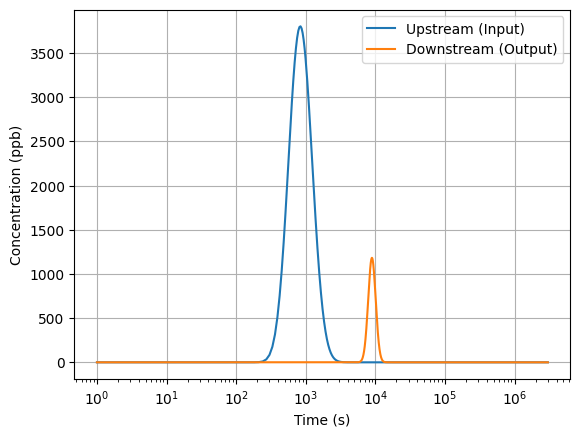

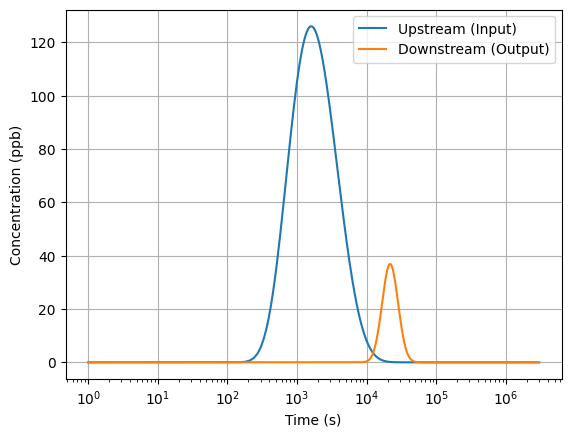

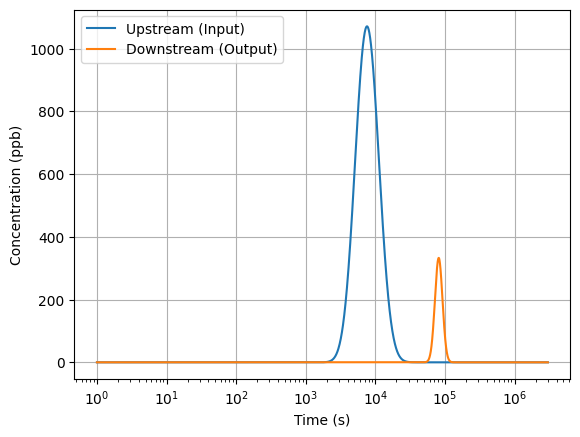

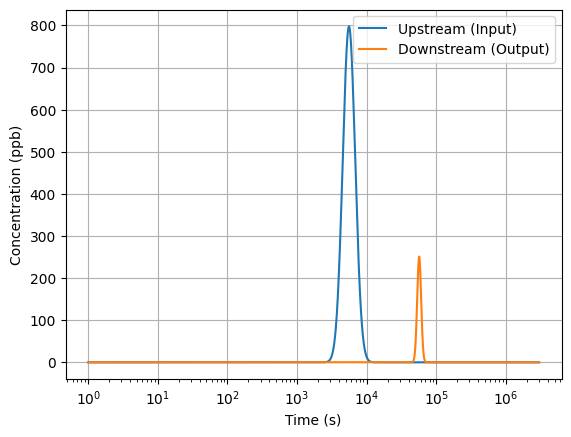

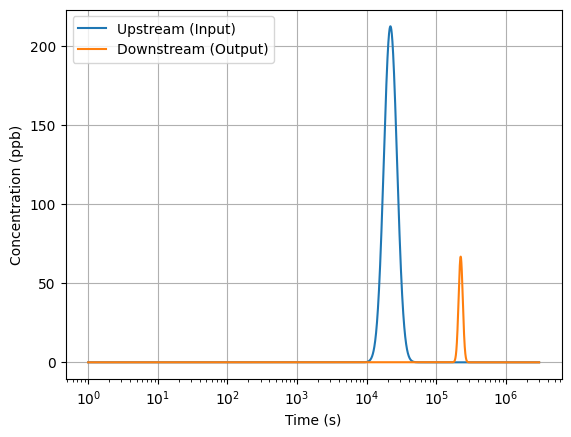

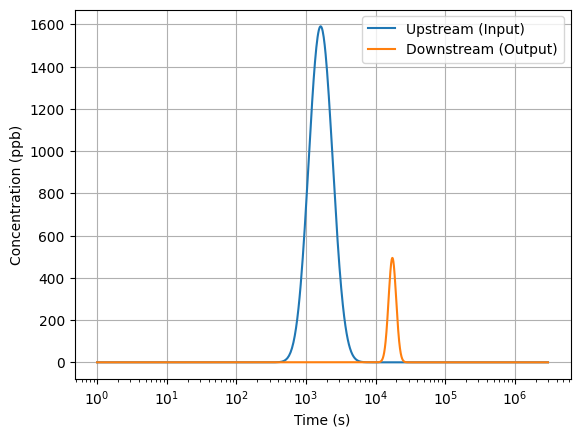

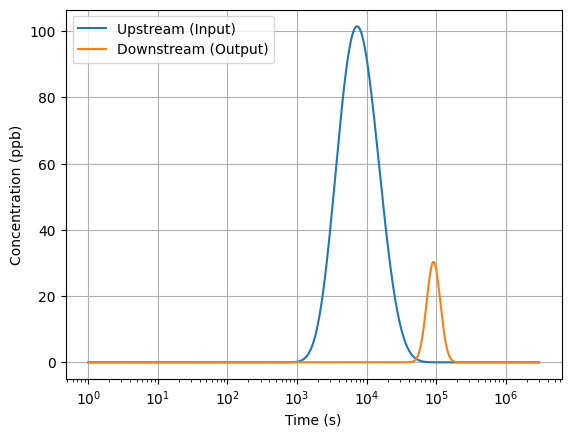

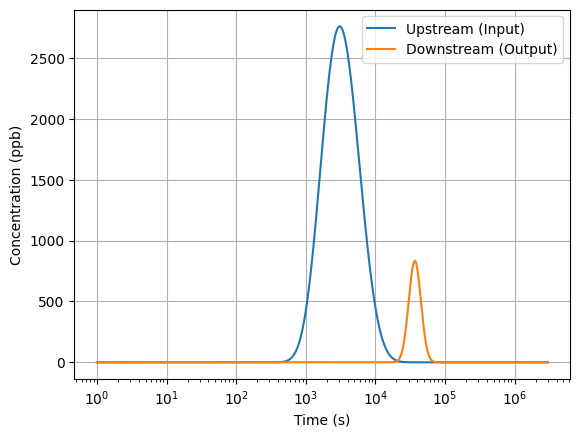

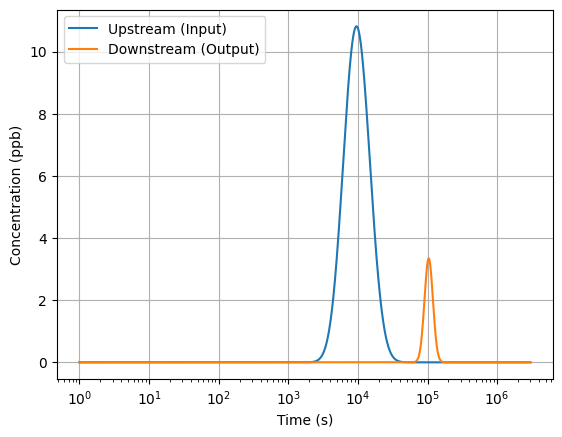

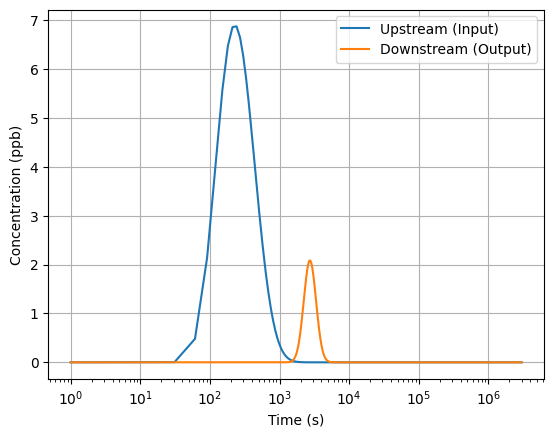

In [ ]:
for i in range(0,10):
  plt.semilogx(t_numpy,c_upstream[i,:],label='Upstream (Input)')

  plt.semilogx(t_numpy,c_downstream[i,:],label='Downstream (Output)')
  plt.legend()
  plt.xlabel('Time (s)')
  plt.ylabel('Concentration (ppb)')
  plt.grid(True)
  plt.show()

In [ ]:
X = torch.tensor(c_upstream,dtype=torch.float32).to(device)
y = torch.tensor(c_downstream,dtype=torch.float32).to(device)

In [ ]:
# Create a dataset
dataset = TensorDataset(X, y)

In [ ]:
# Define split sizes
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
#set_seed(42)

# Split the dataset
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),

            nn.Linear(1024, output_size)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Model, loss, optimizer
input_size = X.shape[1]
output_size = y.shape[1]
model = MLP(input_size, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [ ]:
train_losses = []
val_losses = []

epochs = 800

for epoch in range(epochs):
    model.train()
    running_loss = 0.0  # Track training loss

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()


    # Compute average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Store training loss

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Training Loss: {avg_train_loss:.6f}')

    # Validation step every 30 epochs
    if epoch % 30 == 0:
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append((epoch, avg_val_loss))

        print(f'Epoch {epoch}, Validation Loss: {avg_val_loss:.6f}')

Epoch 0, Training Loss: 906.770085
Epoch 0, Validation Loss: 891.707783
Epoch 30, Validation Loss: 846.432074
Epoch 60, Validation Loss: 783.059152
Epoch 90, Validation Loss: 763.215981
Epoch 100, Training Loss: 830.483198
Epoch 120, Validation Loss: 794.157406
Epoch 150, Validation Loss: 787.377503
Epoch 180, Validation Loss: 839.505494
Epoch 200, Training Loss: 869.881429
Epoch 210, Validation Loss: 1048.073678
Epoch 240, Validation Loss: 597.282679
Epoch 270, Validation Loss: 691.546533
Epoch 300, Training Loss: 488.622633
Epoch 300, Validation Loss: 589.594230
Epoch 330, Validation Loss: 581.583717
Epoch 360, Validation Loss: 494.191977
Epoch 390, Validation Loss: 583.564926
Epoch 400, Training Loss: 463.039013
Epoch 420, Validation Loss: 484.856980
Epoch 450, Validation Loss: 332.387776
Epoch 480, Validation Loss: 282.195132
Epoch 500, Training Loss: 196.329570
Epoch 510, Validation Loss: 274.128508
Epoch 540, Validation Loss: 323.873045
Epoch 570, Validation Loss: 274.642111
Epoc

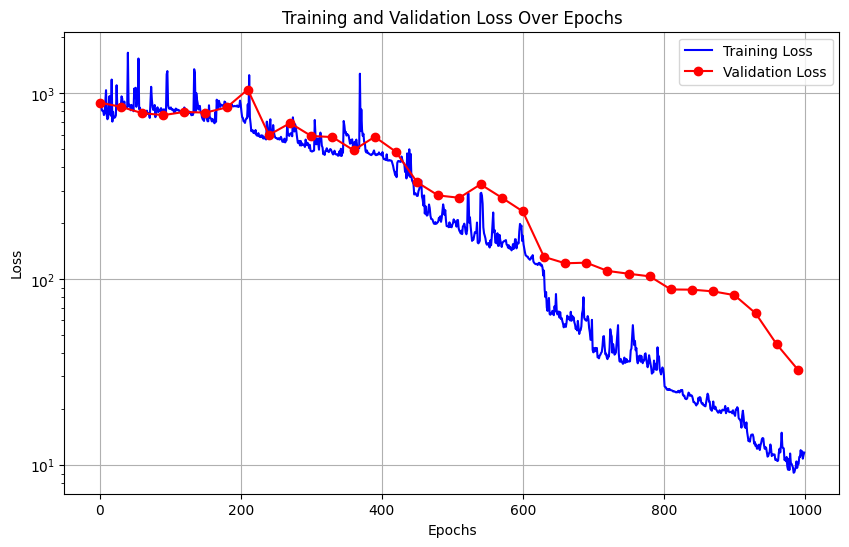

In [ ]:
val_epochs, val_loss_values = zip(*val_losses)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.semilogy(range(epochs), train_losses, label='Training Loss', color='blue')
plt.semilogy(val_epochs, val_loss_values, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Test
model.eval()

actual_curves = []
predicted_curves = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)

        # Move data to CPU for plotting
        actual_curves.extend(batch_y.cpu().numpy())
        predicted_curves.extend(outputs.cpu().numpy())

actual_curves = np.array(actual_curves)
predicted_curves = np.array(predicted_curves)
predicted_curves[predicted_curves < 0] = 0

In [ ]:
max_lag = 100
use_normalize = 'zscore'

cc_results = []
for i in range(actual_curves.shape[0]):
    a = actual_curves[i]
    b = predicted_curves[i]
    res = best_lag_correlation(a, b, max_lag=max_lag, normalize=use_normalize)
    cc_results.append(res)

cc_mean_corr = np.mean([r['corr'] for r in cc_results])
print(f"[Cross-Correlation] Correlación media (al mejor lag): {cc_mean_corr:.4f}")

all_lags = [res['lag'] for res in cc_results]
all_corrs = [res['corr'] for res in cc_results]
all_lags = np.array(all_lags)
all_corrs = np.array(all_corrs)
print("Lags:", all_lags)
print("Correlaciones:", all_corrs)

[0.9780787229537964, 0.9788028597831726, 0.9981527328491211, 0.9961516261100769, 0.9850815534591675, 0.9959958791732788, 0.6957424879074097, 0.8865922689437866, 0.749387800693512, 0.9971576929092407, 0.9944393634796143, 0.9941576719284058, 0.9976423382759094, 0.9866109490394592, 0.9976372122764587, 0.9817612767219543, 0.9957618713378906, 0.9960892796516418, 0.9966810345649719, 0.9894663691520691, 0.9935998320579529, 0.9834482073783875, 0.9902372360229492, 0.9979655742645264, 0.9977285861968994, 0.9918090105056763, 0.9949412941932678, 0.9915980696678162, 0.9871048927307129, 0.7607272863388062, 0.9961950182914734, 0.9768303632736206, 0.9852221608161926, 0.9976367354393005, 0.9944589734077454, 0.9927348494529724, 0.9555294513702393, 0.9965543746948242, 0.9921679496765137, 0.9966440200805664, 0.981109082698822, 0.9504420161247253, 0.995967447757721, 0.9896537065505981, 0.9962387084960938, 0.9963822960853577, 0.9960969090461731, 0.977275550365448, 0.997890830039978, 0.4070475101470947, 0.99

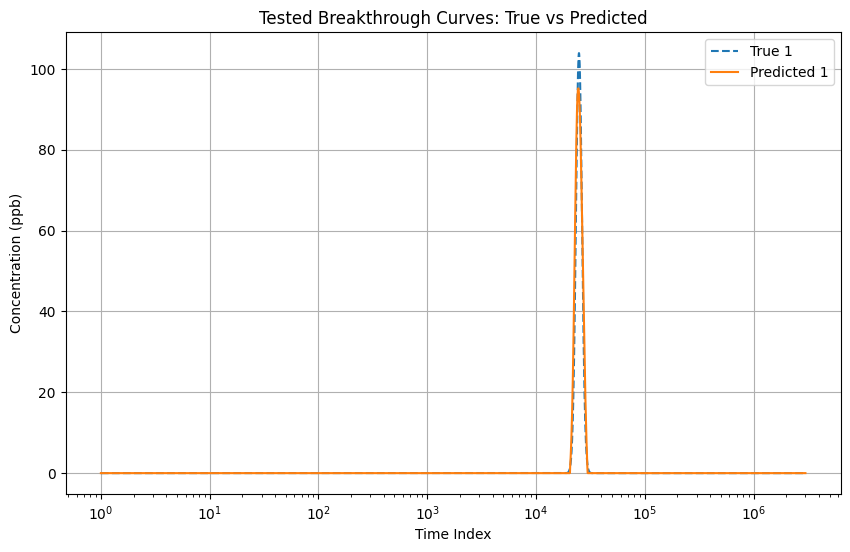

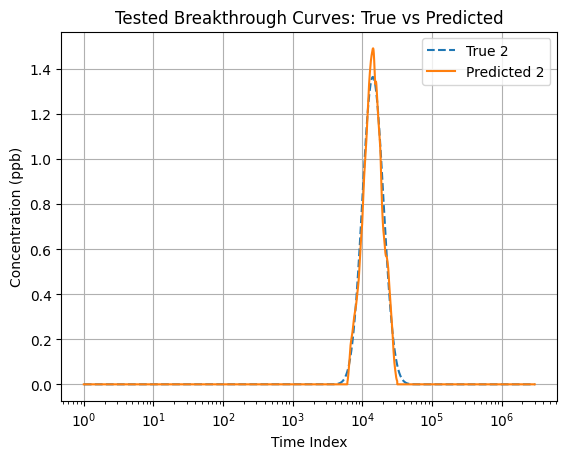

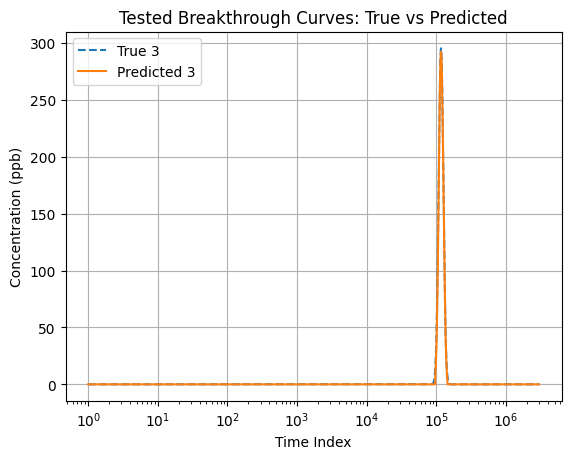

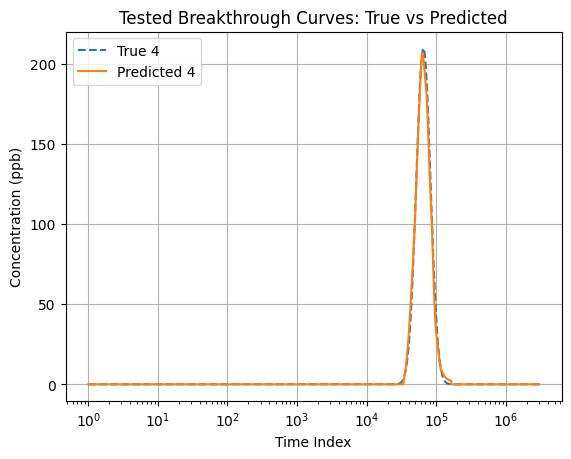

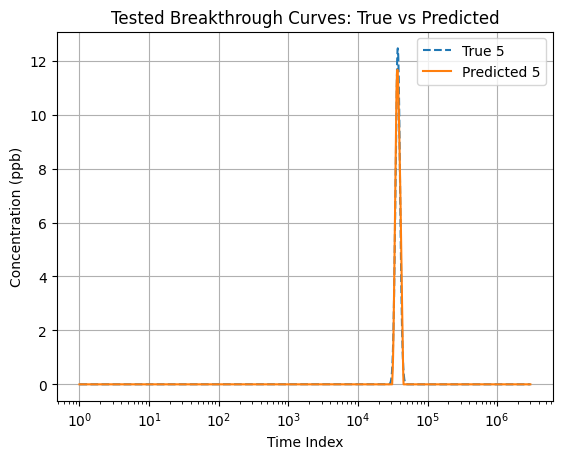

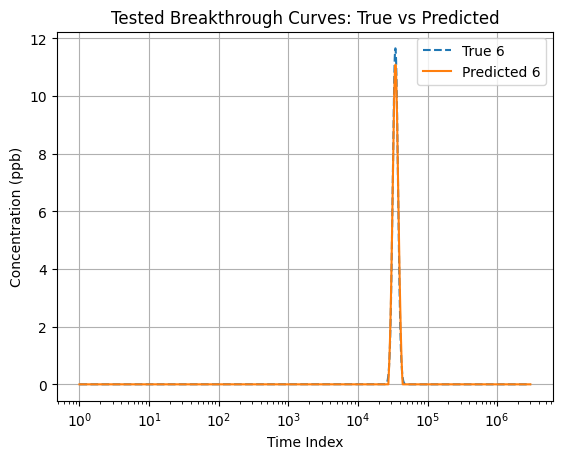

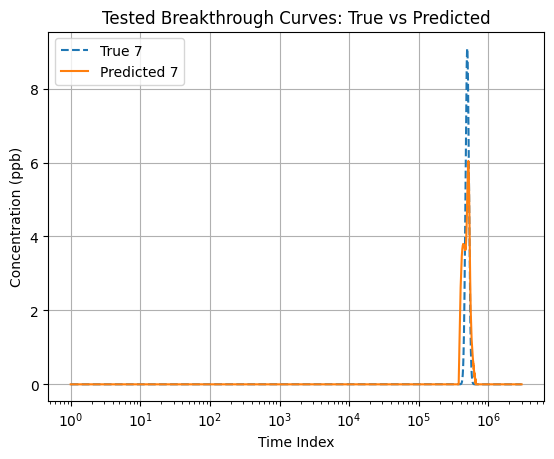

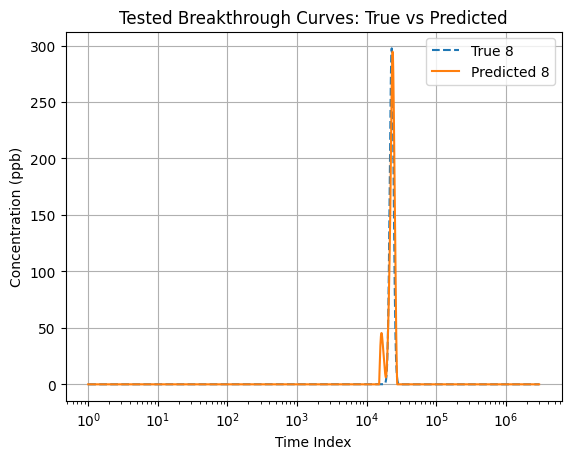

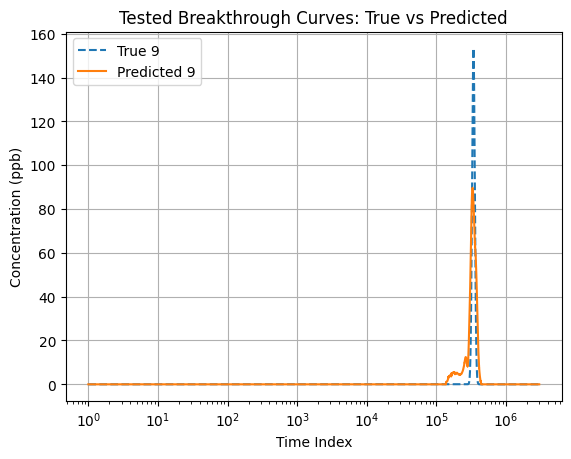

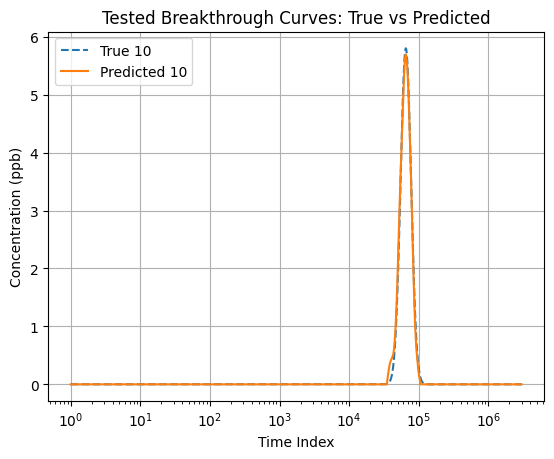

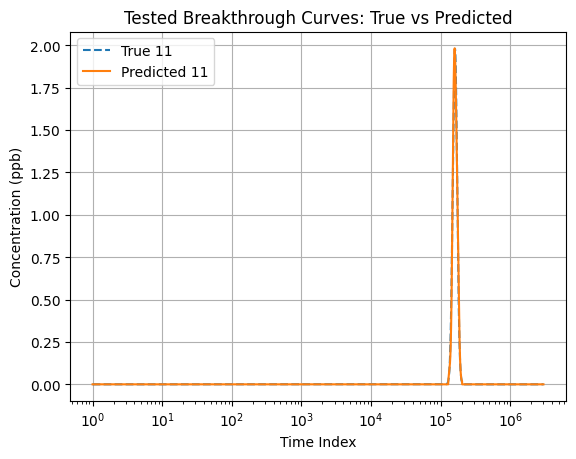

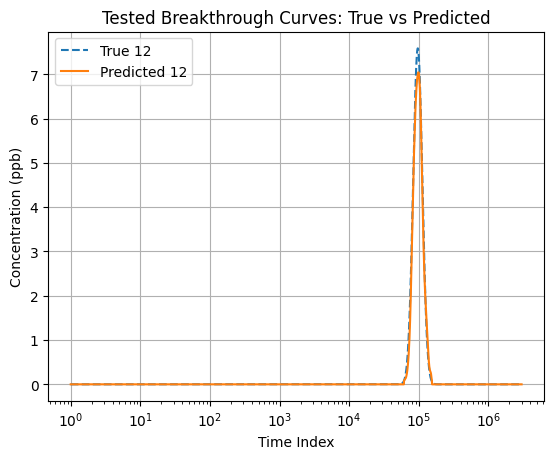

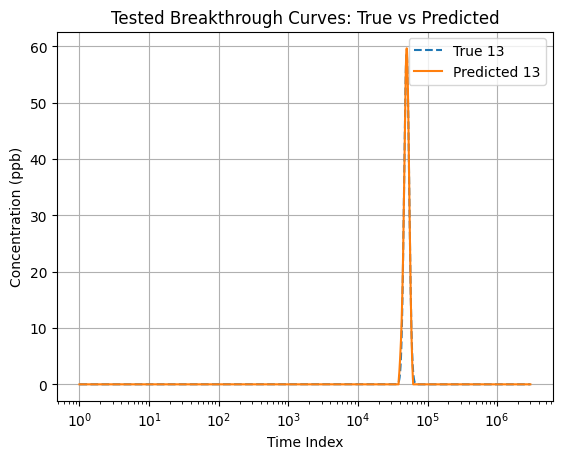

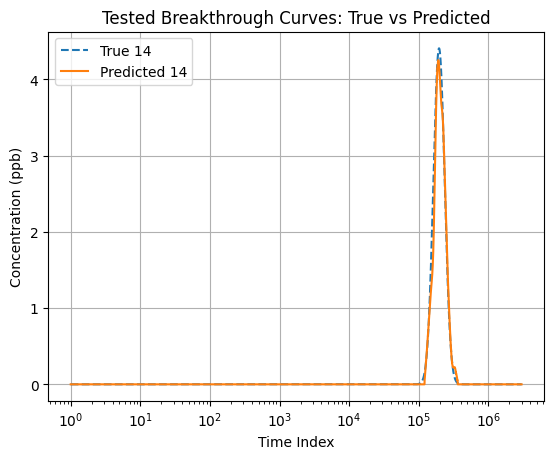

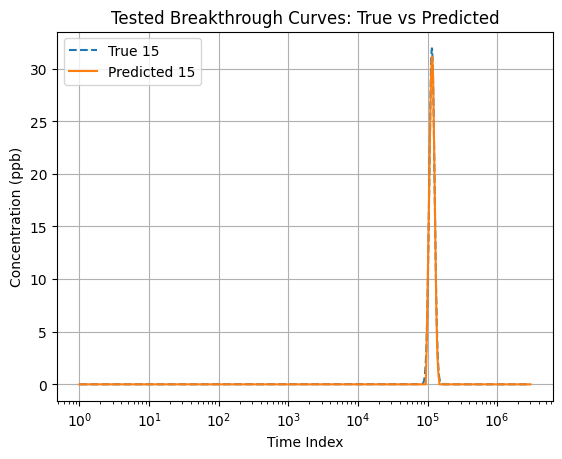

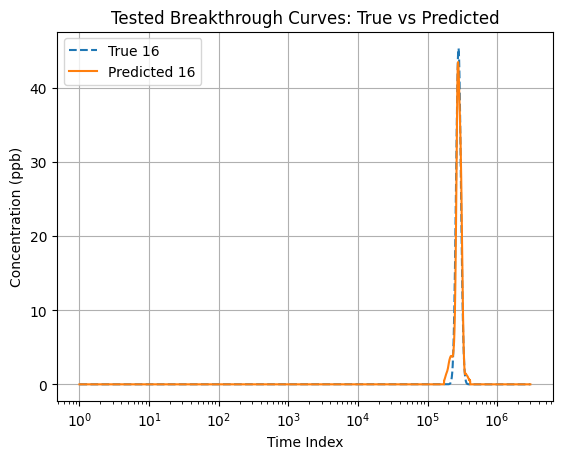

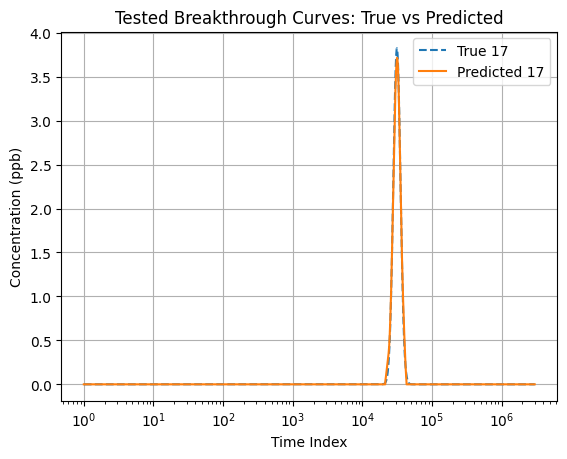

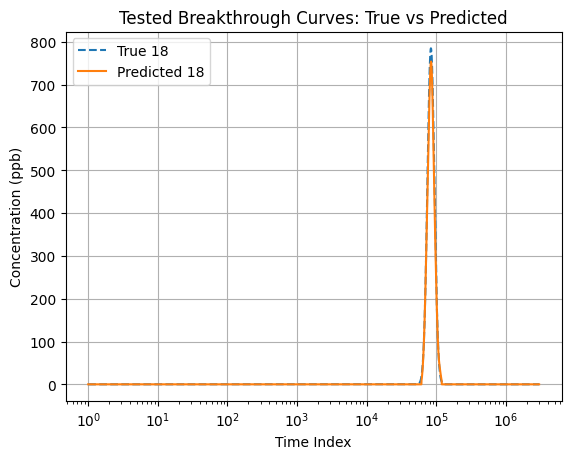

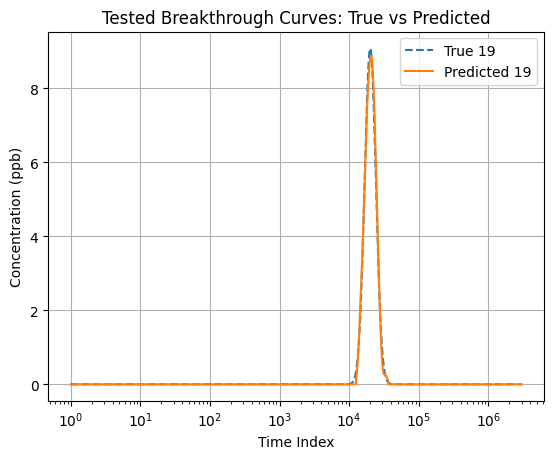

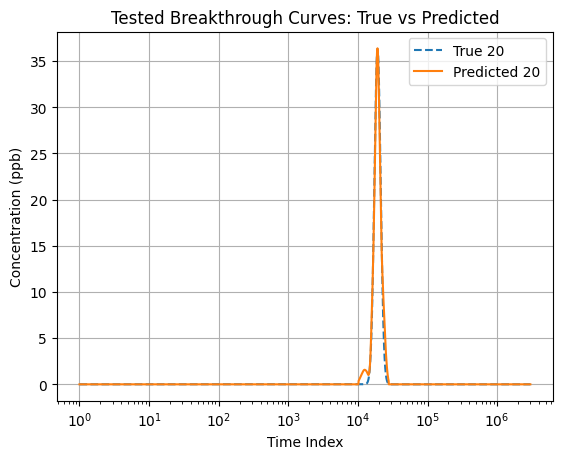

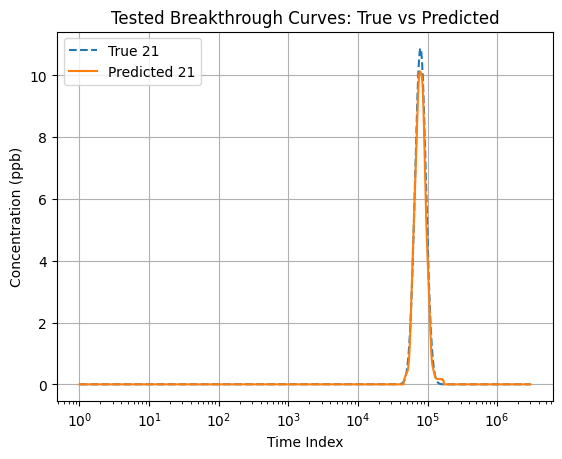

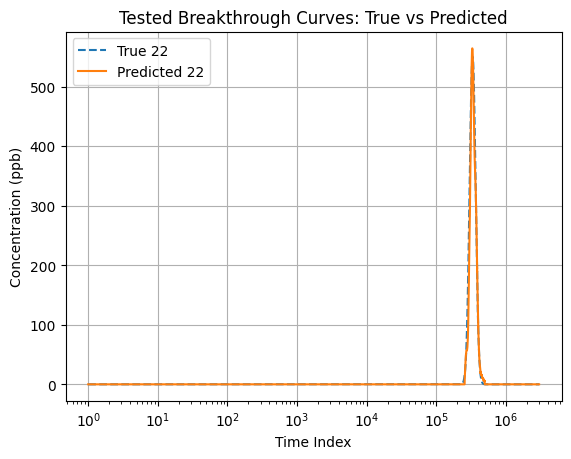

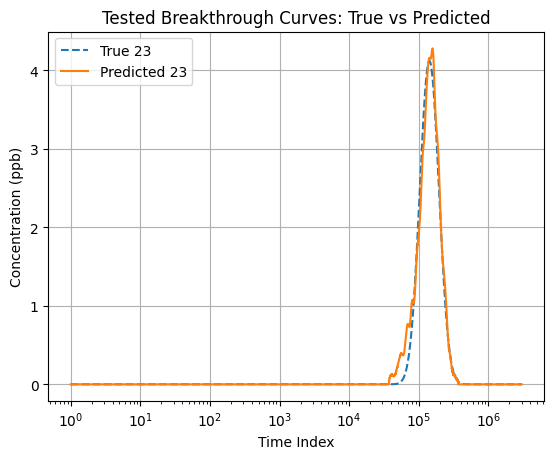

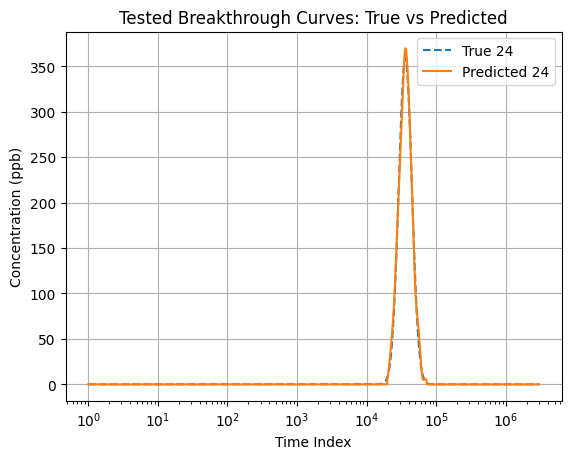

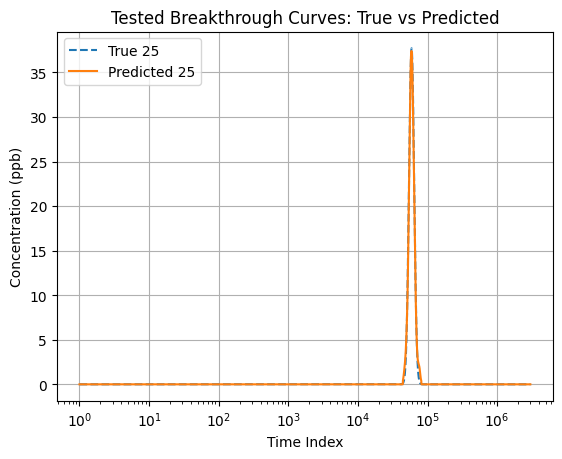

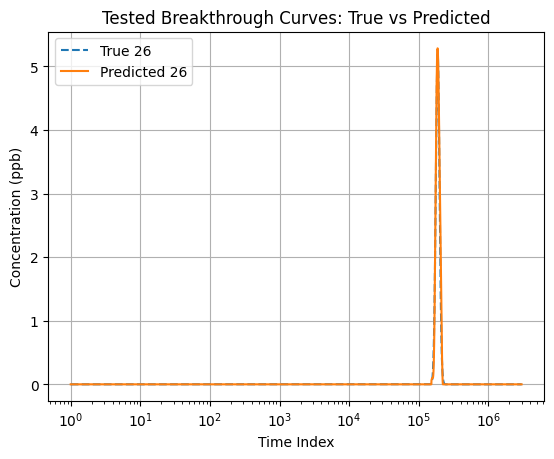

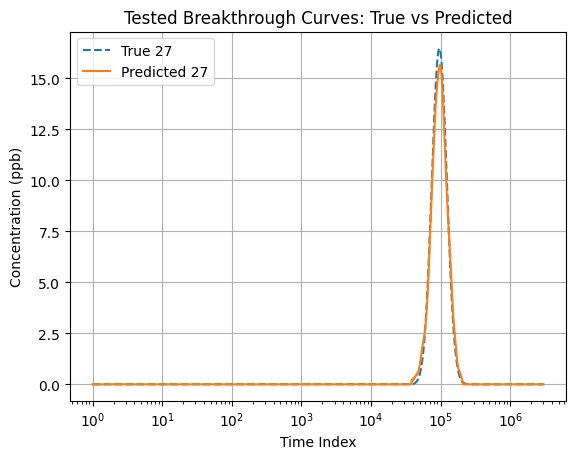

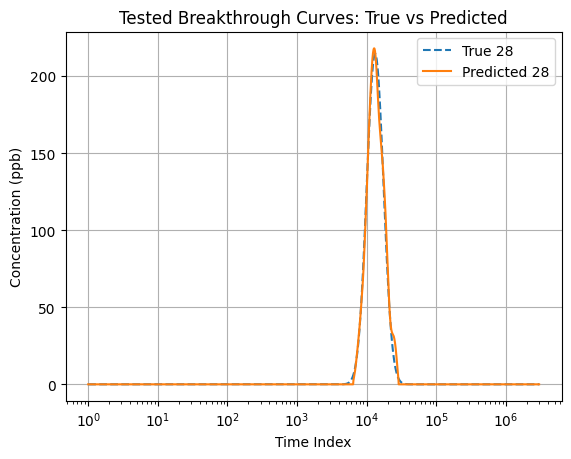

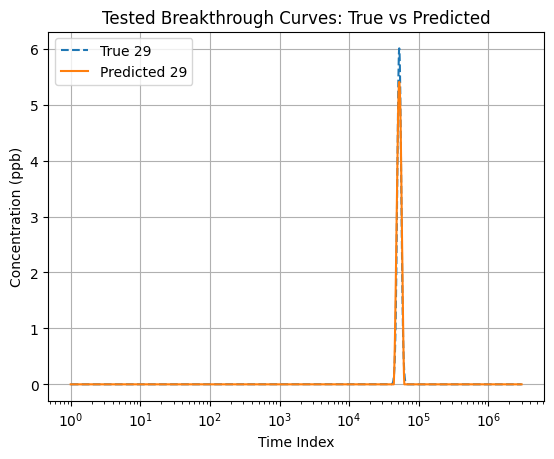

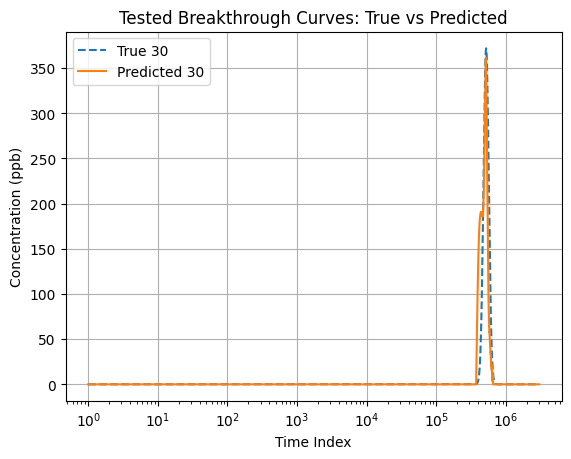

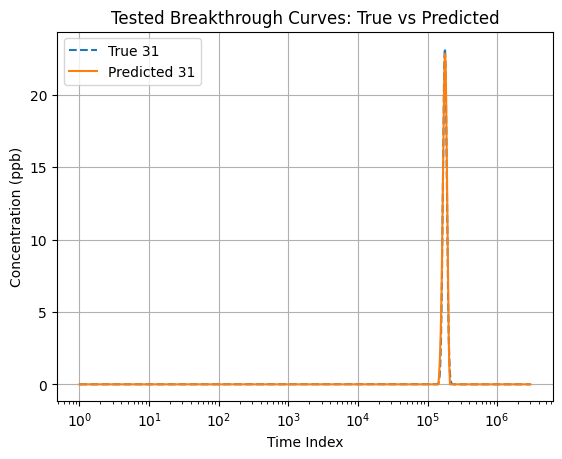

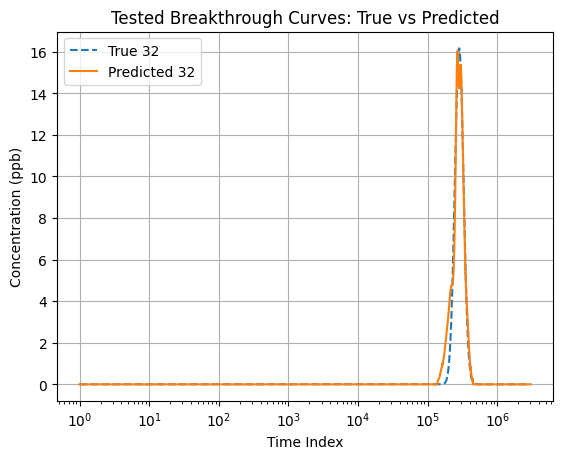

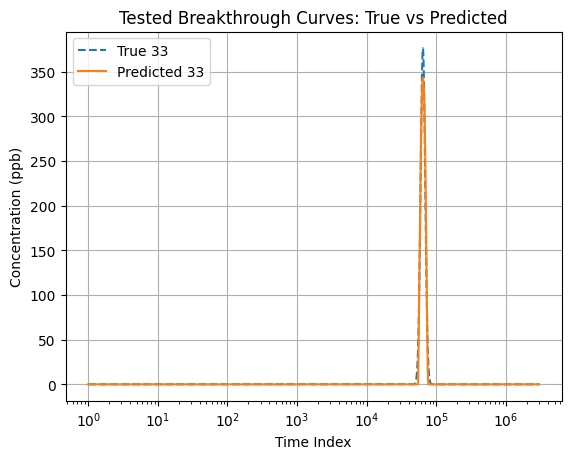

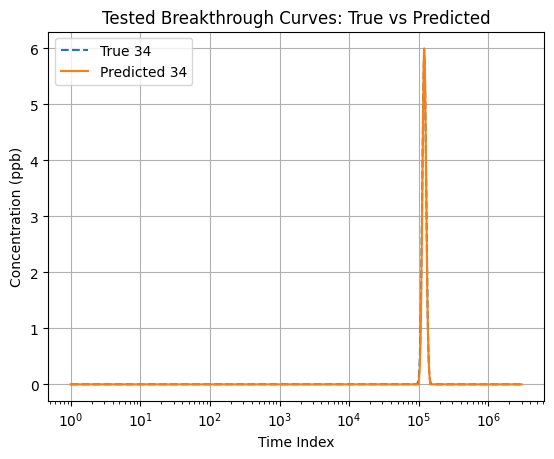

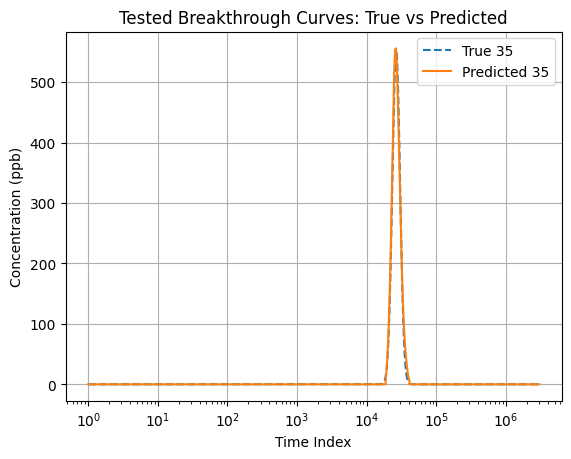

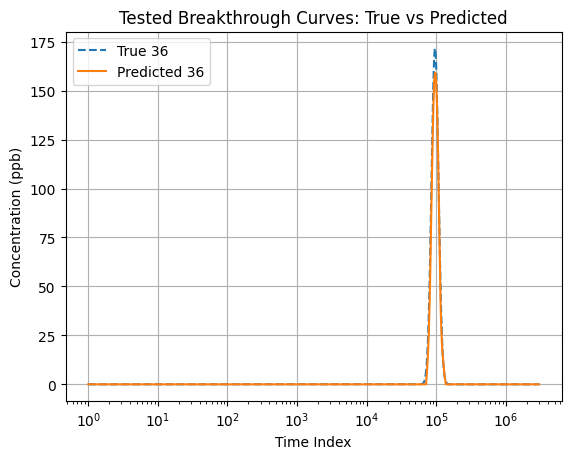

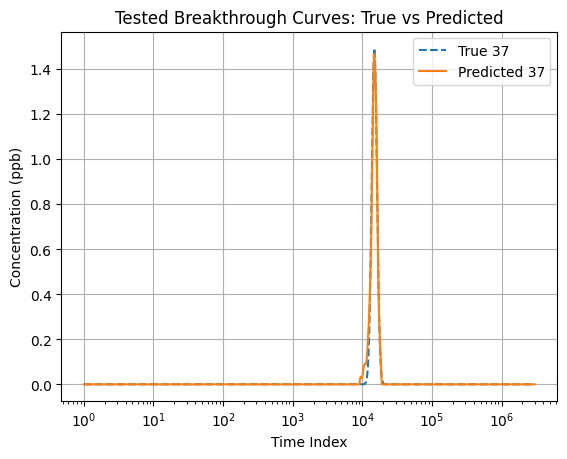

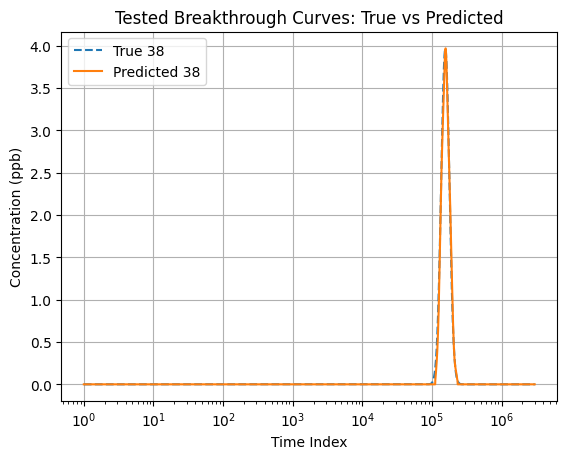

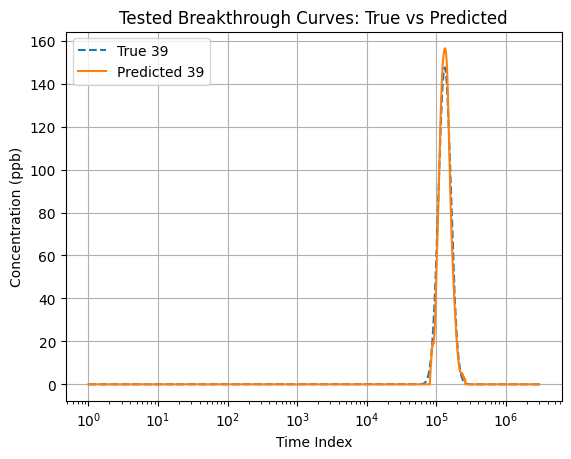

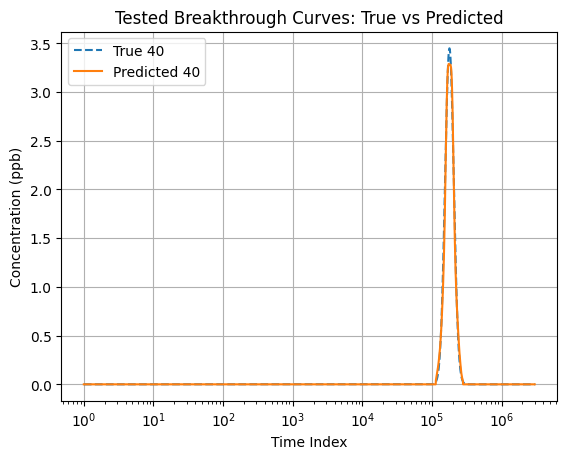

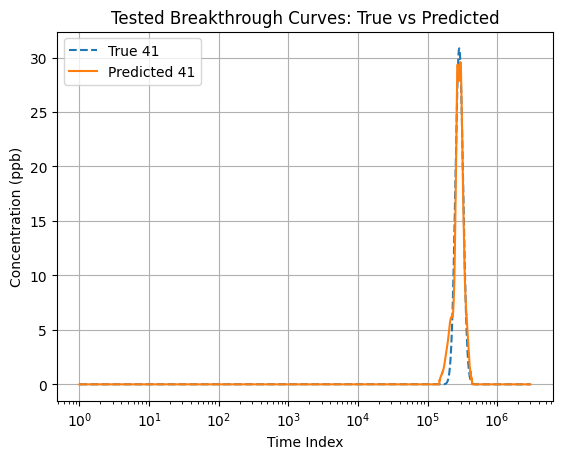

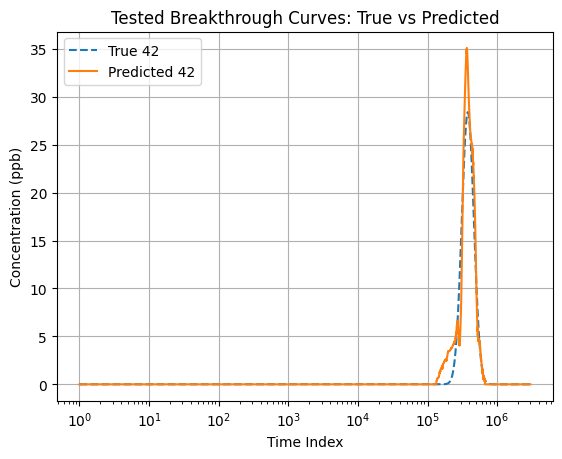

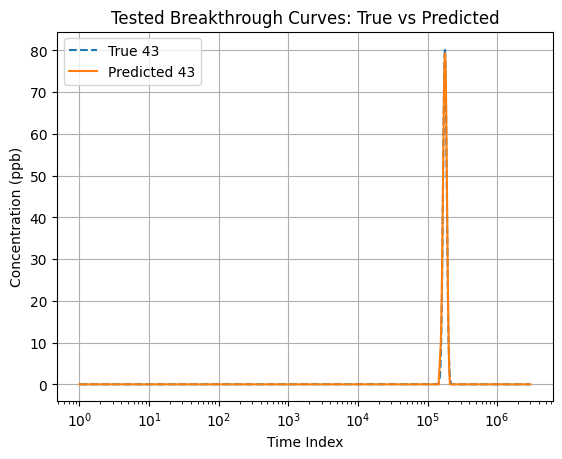

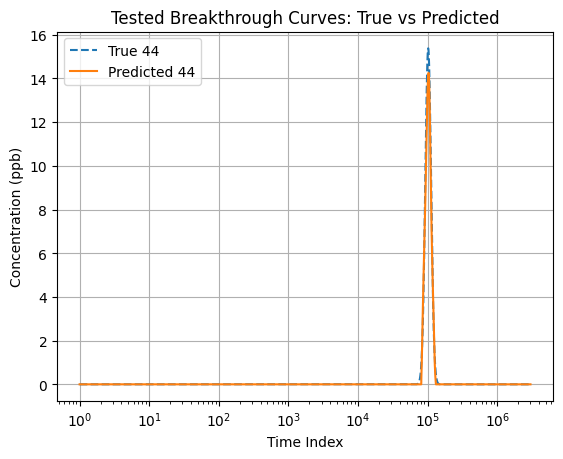

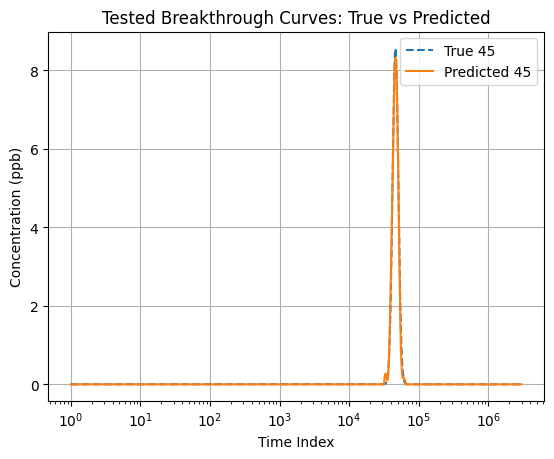

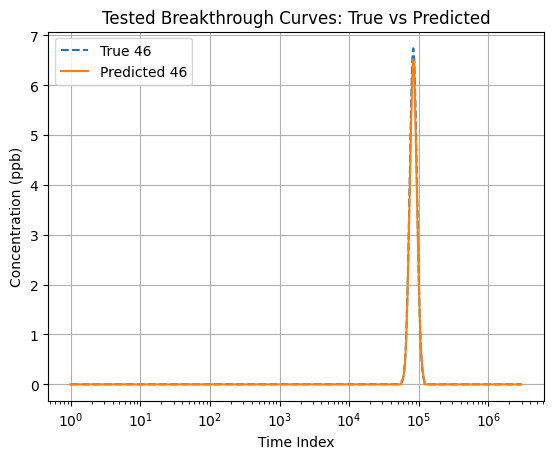

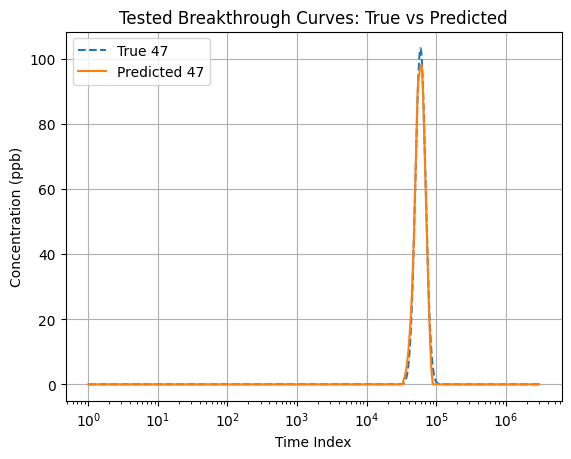

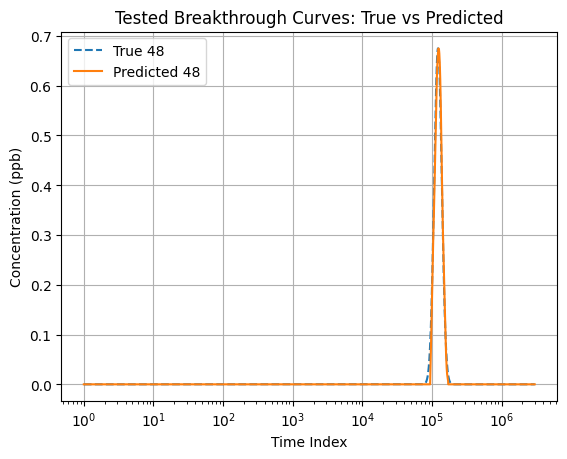

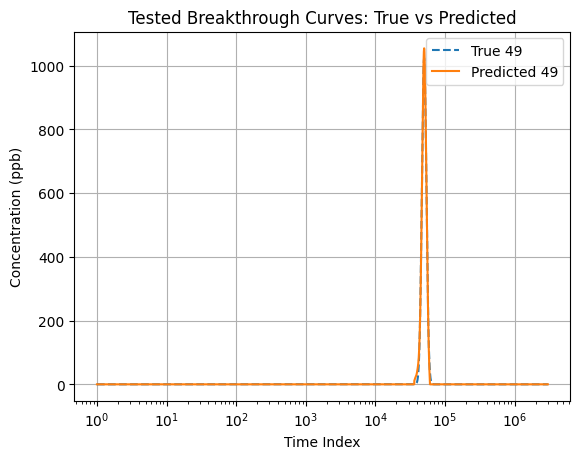

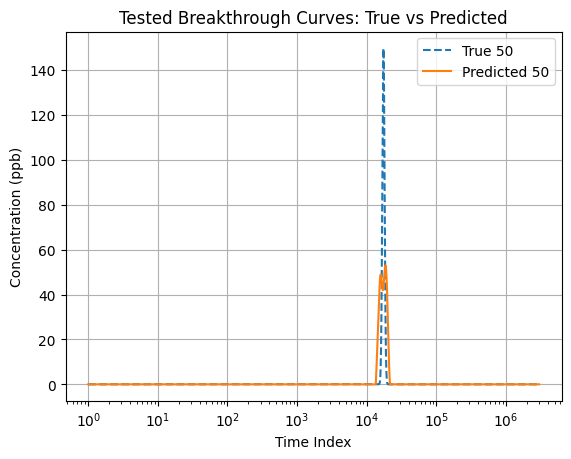

In [ ]:
num_curves_to_plot = len(actual_curves)
plt.figure(figsize=(10, 6))

for i in range(50):
    plt.semilogx(t_numpy, actual_curves[i], label=f'True {i+1}', linestyle='dashed')
    plt.semilogx(t_numpy,smooth_peak(predicted_curves[i]), label=f'Predicted {i+1}', linestyle='solid')
    plt.grid(True)


    plt.xlabel('Time Index')
    plt.ylabel('Concentration (ppb)')
    plt.title('Tested Breakthrough Curves: True vs Predicted')
    plt.legend()
    plt.show()

R² Score for Peak Concentration: 0.968397
R² Score (normalized independently by max): 0.971468
MAPE (%) respecto a 1:1: 10.503894
Bias Ratio: 0.9190699
Absolute errors: [8.71416473e+00 1.27163410e-01 3.12619019e+00 2.70022583e+00
 7.93850899e-01 5.67900658e-01 3.04857111e+00 2.94808960e+00
 6.36257248e+01 1.07158184e-01 2.65133381e-03 5.39202213e-01
 8.58055115e-01 1.54054165e-01 7.65729904e-01 1.85832214e+00
 1.08086586e-01 3.09158936e+01 1.93399429e-01 6.22787476e-02
 7.41192818e-01 1.41887207e+01 1.60706043e-01 1.06802063e+01
 2.97264099e-01 9.24181938e-02 8.18398476e-01 3.59147644e+00
 6.00145817e-01 1.05803223e+01 3.86257172e-01 1.12798691e-01
 3.26586304e+01 1.58904552e-01 4.78912354e+00 1.24579926e+01
 2.46481895e-02 5.90467453e-03 8.91532898e+00 1.59834862e-01
 1.29353905e+00 6.65911865e+00 1.17932129e+00 1.12156296e+00
 2.42109299e-01 2.23731518e-01 5.10476685e+00 6.24835491e-04
 3.08925171e+01 9.66476898e+01 4.67769623e-01 2.35595036e+00
 3.16740334e-01 2.23543167e+00 2.74665

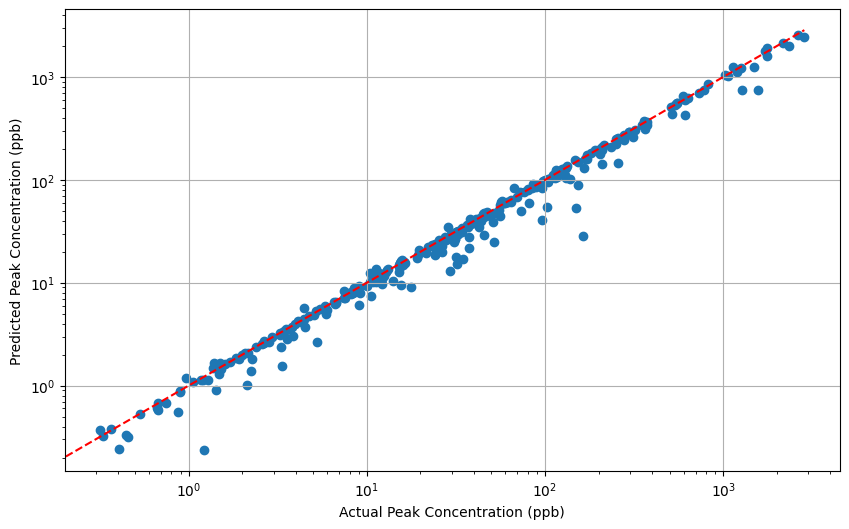

In [ ]:
# Peak concentration
actual_peak = []
predicted_peak = []

for i in range(actual_curves.shape[0]):
    actual_peak.append(np.max(actual_curves[i, :]))
    predicted_peak.append(np.max(predicted_curves[i, :]))

actual_peak = np.array(actual_peak)
predicted_peak = np.array(predicted_peak)

# R2
r2_peak = r2_score(actual_peak, predicted_peak)
print(f'R² Score for Peak Concentration: {r2_peak:.6f}')

# MAPE
mape = np.mean(np.abs((predicted_peak - actual_peak) / actual_peak)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIS RATIO
y_true = actual_peak
y_pred = predicted_peak
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print("Bias Ratio:", bias_ratio)


x1 = np.linspace(0, np.max(actual_peak))
y1=x1
plt.figure(figsize=(10, 6))
plt.scatter(actual_peak,predicted_peak)
plt.plot(x1,y1, linestyle='--', color='r')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.ylabel('Predicted Peak Concentration (ppb)')
plt.xlabel('Actual Peak Concentration (ppb)')
plt.show()

R² Score for Peak Time: 0.591033
R² Score (normalized independently by max): 0.390909
MAPE (%) respecto a 1:1: 3.545670063845674
Bias ratio: 0.917
Absolute errors: [3.60003480e+02 9.00008700e+01 9.00008700e+01 2.01001943e+03
 4.80004640e+02 6.00005800e+01 1.76701708e+04 7.20006960e+02
 9.60009280e+03 1.50001450e+02 1.89001827e+03 2.01001943e+03
 3.00002900e+01 4.77004611e+03 6.00005800e+02 3.72003596e+03
 2.70002610e+02 3.30003190e+02 4.50004350e+02 6.00005800e+01
 1.29001247e+03 3.69003567e+03 1.53601485e+04 3.00002900e+02
 2.70002610e+02 7.20006960e+02 1.98001914e+03 4.20004060e+02
 0.00000000e+00 5.07004901e+03 7.50007250e+02 1.57201520e+04
 3.00002900e+01 0.00000000e+00 4.80004640e+02 7.50007250e+02
 0.00000000e+00 1.32001276e+03 6.60006380e+02 3.69003567e+03
 1.09801061e+04 1.26301221e+04 6.90006670e+02 1.14001102e+03
 3.00002900e+01 3.90003770e+02 1.50001450e+03 2.61002523e+03
 3.00002900e+01 1.17001131e+03 1.80001740e+03 6.93006699e+03
 9.30008990e+02 3.30003190e+02 9.90009570e+

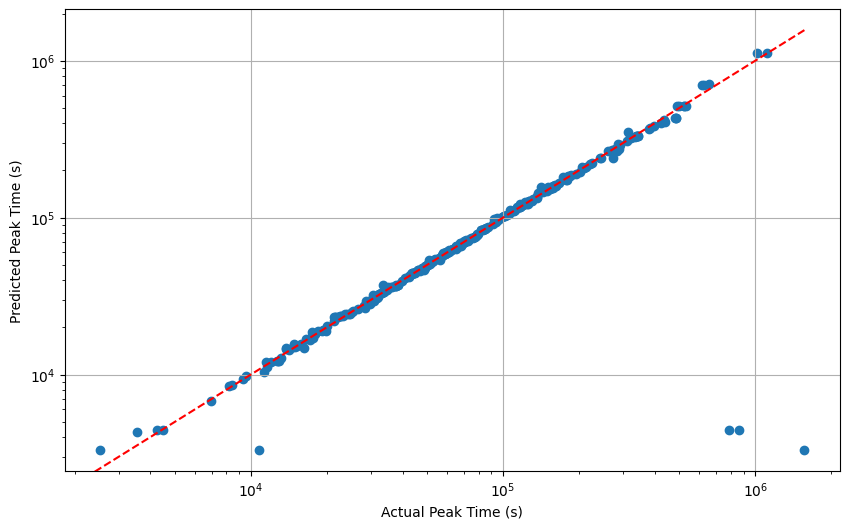

In [ ]:
# Peak time (argmax of each curve)
actual_peaktime = []
predicted_peaktime = []

for i in range(actual_curves.shape[0]):
    actual_peaktime.append(t_numpy[np.argmax(actual_curves[i, :])])
    predicted_peaktime.append(t_numpy[np.argmax(predicted_curves[i, :])])

# Convert to arrays
actual_peaktime = np.array(actual_peaktime)
predicted_peaktime = np.array(predicted_peaktime)

# R2
r2_peaktime = r2_score(actual_peaktime, predicted_peaktime)
print(f'R² Score for Peak Time: {r2_peaktime:.6f}')

#MAPE
mape = np.mean(np.abs((predicted_peaktime - actual_peaktime) / actual_peaktime)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_peaktime
y_pred = predicted_peaktime
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x2 = np.linspace(0, np.max(actual_peaktime)+100)
y2=x2
plt.figure(figsize=(10, 6))
plt.scatter(actual_peaktime,predicted_peaktime)
plt.plot(x2,y2,linestyle='--', color='r')
plt.ylabel('Predicted Peak Time (s)')
plt.xlabel('Actual Peak Time (s)')
plt.yscale('log')
plt.grid(True)
plt.xscale('log')
plt.show()

R² Score for M0: 0.980816
R² Score (normalized independently by max): 0.980812
MAPE (%) respecto a 1:1: 6.99022447829228
Bias ratio: 0.987


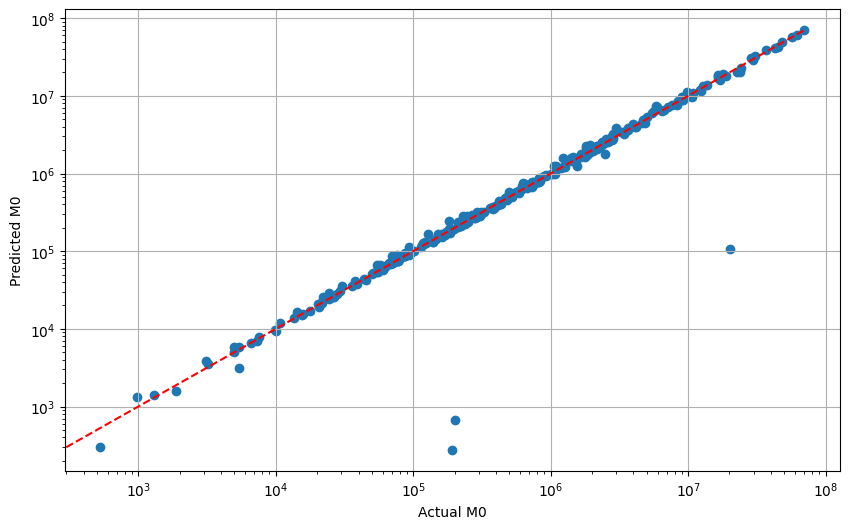

In [ ]:
actual_m0 =[]
predicted_m0 =[]

for i in range(actual_curves.shape[0]):
    actual_m0.append(np.trapezoid(actual_curves[i,:],t_reshape))
    predicted_m0.append(np.trapezoid(smooth_peak(predicted_curves[i,:]),t_reshape))

actual_m0 = np.array(actual_m0)
predicted_m0 = np.array(predicted_m0)

# R2
r2_m0 = r2_score(actual_m0, predicted_m0)
print(f'R² Score for M0: {r2_m0:.6f}')

# MAPE
mape = np.mean(np.abs((predicted_m0 - actual_m0) / actual_m0)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_m0
y_pred = predicted_m0
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x3 = np.linspace(0, np.max(actual_m0))
y3=x3
plt.figure(figsize=(10, 6))
plt.scatter(actual_m0,predicted_m0)
plt.plot(x3,y3,linestyle='--', color='r')
plt.ylabel('Predicted M0')
plt.xlabel('Actual M0')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

R² Score for M1: 0.819571
R² Score (normalized independently by max): 0.818609
MAPE (%) respecto a 1:1: 6.9686165720440325
Bias ratio: 0.906


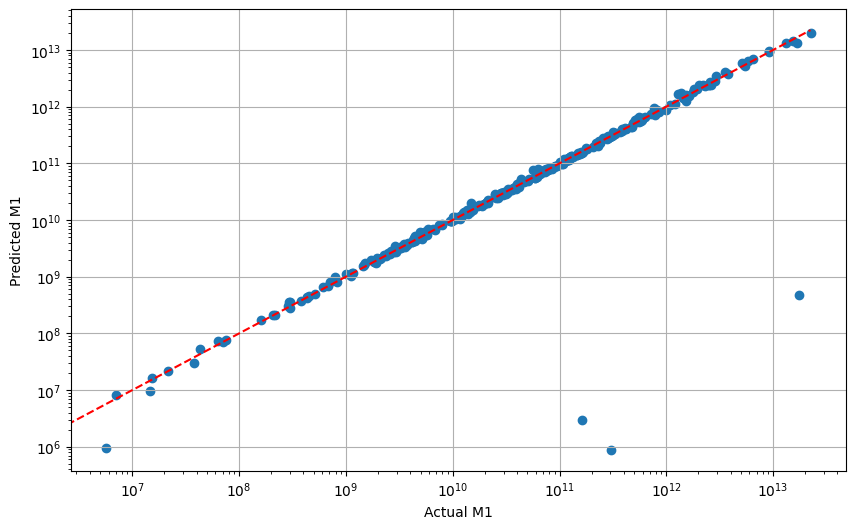

In [ ]:
actual_m1 = []
predicted_m1 = []

for i in range(actual_curves.shape[0]):
    actual_moment = actual_curves[i,:]*t_reshape
    predicted_moment = smooth_peak(predicted_curves[i,:])*t_reshape

    actual_m1.append(np.trapezoid(actual_moment,t_reshape))
    predicted_m1.append(np.trapezoid(predicted_moment,t_reshape))

actual_m1 = np.array(actual_m1)
predicted_m1 = np.array(predicted_m1)

# R2
r2_m1 = r2_score(actual_m1,predicted_m1)
print(f'R² Score for M1: {r2_m1:.6f}')

# MAPE
mape = np.mean(np.abs((predicted_m1 - actual_m1) / actual_m1)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_m1
y_pred = predicted_m1
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x4 = np.linspace(0, np.max(actual_m1)+100)
y4=x4
plt.figure(figsize=(10, 6))
plt.scatter(actual_m1,predicted_m1)
plt.plot(x4,y4,linestyle='--', color='r')
plt.ylabel('Predicted M1')
plt.xlabel('Actual M1')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)

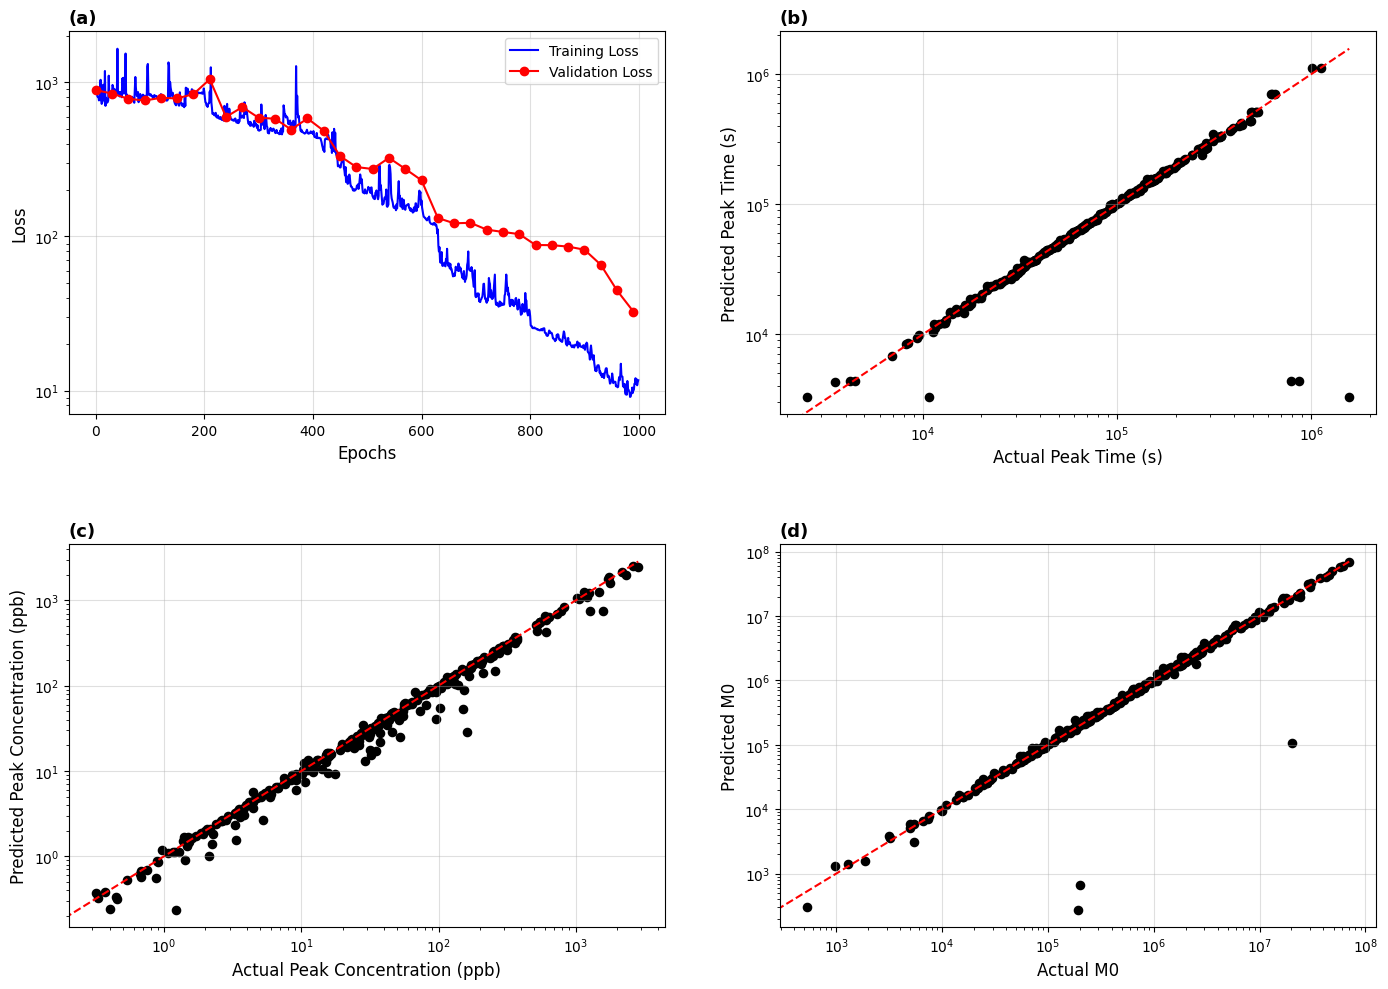

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

(a) Training vs Validation Loss
axes[0, 0].semilogy(range(len(train_losses)), train_losses, label='Training Loss', color='blue')
axes[0, 0].semilogy(val_epochs, val_loss_values, label='Validation Loss', color='red', marker='o')
axes[0, 0].set_xlabel('Epochs', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.4)
axes[0, 0].set_title('(a)', loc='left', fontsize=13, fontweight='bold')

#(b) Peak Time
x2 = np.linspace(0, np.max(actual_peaktime) + 100)
y2 = x2
axes[0, 1].scatter(actual_peaktime, predicted_peaktime, color='black', s=35)
axes[0, 1].plot(x2, y2, linestyle='--', color='r')
axes[0, 1].set_xlabel('Actual Peak Time (s)', fontsize=12)
axes[0, 1].set_ylabel('Predicted Peak Time (s)', fontsize=12)
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.4)
axes[0, 1].set_title('(b)', loc='left', fontsize=13, fontweight='bold')

#(c) Peak Concentration
x1 = np.linspace(0, np.max(actual_peak))
y1 = x1
axes[1, 0].scatter(actual_peak, predicted_peak, color='black', s=35)
axes[1, 0].plot(x1, y1, linestyle='--', color='r')
axes[1, 0].set_xlabel('Actual Peak Concentration (ppb)', fontsize=12)
axes[1, 0].set_ylabel('Predicted Peak Concentration (ppb)', fontsize=12)
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.4)
axes[1, 0].set_title('(c)', loc='left', fontsize=13, fontweight='bold')

# (d) M0
x3 = np.linspace(0, np.max(actual_m0))
y3 = x3
axes[1, 1].scatter(actual_m0, predicted_m0, color='black', s=35)
axes[1, 1].plot(x3, y3, linestyle='--', color='r')
axes[1, 1].set_xlabel('Actual M0', fontsize=12)
axes[1, 1].set_ylabel('Predicted M0', fontsize=12)
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.4)
axes[1, 1].set_title('(d)', loc='left', fontsize=13, fontweight='bold')

plt.tight_layout(w_pad=4, h_pad=4)
plt.show()

In [ ]:
# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses
}, "/content/drive/MyDrive/model_checkpoint_pretrained_.pth") # Update to your local path